# CESM2-LE analysis  of snow melt and runoff
## Statistical Changes 
- Reading in ensemble of data from CESM2-LE, Rodgers et al 2021 ESD https://doi.org/10.5194/esd-2021-50
- Initial file IO from Daniel Kennedy djk2120@ucar.edu, modified Will Wieder wwieder@ucar.edu with improvements from Anderson Banihirwe abanihi@ucar.edu

### Looks at changes in the mean state and variability from individual grid cells
- This script reads in summary data from daily output (generated by StatChangePreprocess) and 
- Calculates ensemble statistics from 40 members of the CESM2_LE
- Plots maps of ensemble changes in means state and variability associated with annual SWE and Runoff metrics

### Creates Figures
- Figs 4a-b & S8-S9 maps of ensemble changes in SWE & Runoff mean state and variability  
- Fig 5 & Sxx Scatter plot and maps of changes in SWE-RUNOFF predictability 


In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal,stats
from tqdm.auto import tqdm
from distributed import wait
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Fetch cluster

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='25GB')
cluster.scale(20) 

In [4]:
cluster

------
## Read in annual summary of CESM2-LE and concatinate dataset

In [5]:
pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileIN =  pathIN + 'SnowStatsSWE*.nc'

ds = xr.open_mfdataset(fileIN,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
_ = wait(ds)
print(' -- Data read in -- ')

 -- Data read in -- 


In [6]:
# Need to make last year of runoff variables zero
qvars = ['MaxQrun','MaxQrunDate','TotQrun','WinMELT','f_WinMELT','CT']
for i in range(len(qvars)):
    ds[qvars[i]] = ds[qvars[i]].where(ds.time<2100)

ds['SnowFree'].attrs['long_name'] = "Snow free days"

In [7]:
# get grid cell areas
samplefile = ('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/'+
              'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')

file = xr.open_dataset(samplefile)
la = file['area']*file['landfrac']
la = la.sel(lat=slice(25,85))

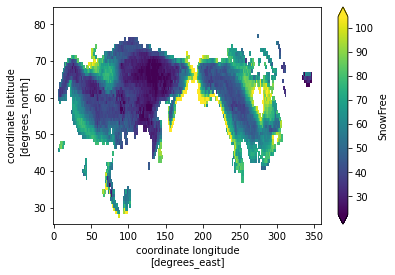

In [9]:
#Mask out missing values (again)
ds = ds.where(ds['SnowFree']>=0)
(ds.SnowFree.isel(time=-1)-ds.SnowFree.isel(time=0)).mean('ens').plot(robust=True);

In [10]:
nens = len(ds.ens)
Nens = int(nens+1)

----
## Ensemble correlations between SWE and RUNOFF at each gridcell

/glade/scratch/wwieder/VernalWindow/Fig5a_SWE_RUNOFF_CORR.pdf


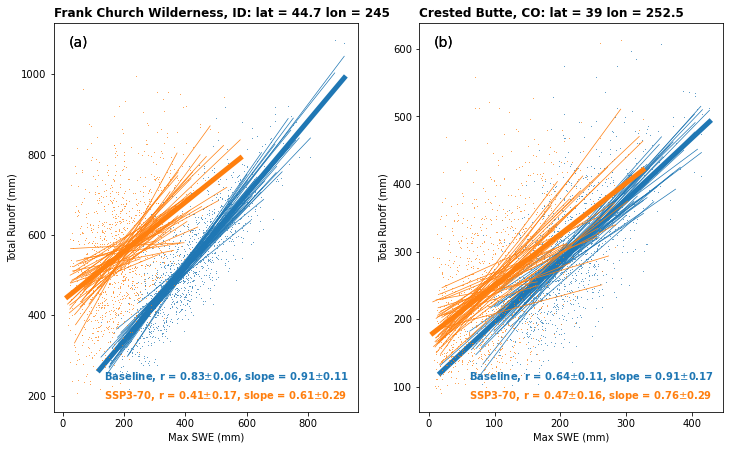

In [11]:
plat = [44.7, 39,40]
plon = [360-115,252.5, 254]
site = ['Frank Church Wilderness, ID', 'Crested Butte, CO', 'Niwot Ridge, CO']
ID = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)'] #panel IDs

fig = plt.figure(figsize=[12,8])
fig.subplots_adjust(top=0.8)
Pscale = [1.08, 0.99]
# create arrays to store individual ensemble results
r_out, slope_out = np.zeros([2,2,Nens]), np.zeros([2,2,Nens])

for P in range(2):
    ax = fig.add_subplot(1,2,(P+1))
    ax.set_xlabel('Max SWE (mm)')
    ax.set_ylabel('Total Runoff (mm)')

    col=['tab:blue','tab:orange']
    firstY= [90, 220] #first and last years to sample
    lastY = [120,250]
    for t in range(2):
        for e in range(Nens):
            if e < nens:
                plotData = ds.isel(
                    ens = e,
                    time=slice(firstY[t],lastY[t])).sel(
                    lat = plat[P], lon = plon[P], method='nearest')
            else:
                plotData = ds.isel(
                    time=slice(firstY[t],lastY[t])).sel(
                    lat = plat[P], lon = plon[P], method='nearest')
            # calculate regression stats    
            x = plotData.MaxSnow.to_dataframe().dropna(how='all')['MaxSnow'].to_numpy()
            y = plotData.TotQrun.to_dataframe().dropna(how='all')['TotQrun'].to_numpy()
            y2 = y#np.where(y<10, y, np.nan)
            model = LinearRegression().fit(x.reshape((-1, 1)), y2)
            R, p = stats.pearsonr(x,y)
            R  = np.round(R, 2)
            R2 = np.round(R*R, 2)
            slope = np.round(model.coef_[0],2)            
            # Write out stats for each point, time, & ensemble member
            r_out[P,t,e] = R  
            slope_out[P,t,e] = slope

            xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
            yPred = model.predict(xRange)
            yRange= np.array([y.min(),y.max()]).reshape(-1, 1)

            xlim=xRange*1.1
            ylim=yRange*1.
            if e == nens:
                ax.plot(x, y,',',color=col[t],alpha=0.7)
                ax.plot(xRange,yPred,color=col[t],lw=5)
            else:
                ax.plot(xRange,yPred,color=col[t],lw=0.7)

        # add labels and legend w/ statistics
        ax.annotate(ID[P], xy=(0.08, 0.95), xycoords=ax.transAxes,
                    ha='center', va='center',fontsize=14) 
        ax.set_title(site[P]+': lat = '+str(plat[P])+' lon = '+str(plon[P]), 
                     loc='left', fontsize='large', fontweight='bold')
        legend_properties = {'weight':'bold'}
        ax.legend([('Baseline, r = '+
                    str(r_out[P,0,e])+r'$ \pm $'+
                    str(np.round(r_out[P,0,0:nens].std(),2))+
                    ', slope = '+
                    str(np.round(slope_out[P,0,e],2))+r'$ \pm $'+
                    str(np.round(slope_out[P,0,0:nens].std(),2))),
                   (#str(ds.time.isel(time=firstY[1]).values)+'-'+str(ds.time.isel(time=lastY[1]).values)+
                    'SSP3-70, r = '+
                    str(r_out[P,1,e])+r'$ \pm $'+
                    str(np.round(r_out[P,1,0:nens].std(),2))+
                    ', slope = '+
                    str(np.round(slope_out[P,1,e],2))+r'$ \pm $'+
                    str(np.round(slope_out[P,1,0:nens].std(),2))),
                  ],
                frameon=False,fontsize='xx-large', prop=legend_properties, 
                labelcolor=col,markerscale=0,handlelength=0,
                loc='lower right')

pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathIN + 'Fig5a_SWE_RUNOFF_CORR.pdf'
print(fileOUT)
plt.savefig(fileOUT)       

In [12]:
# Print stats for all 
for P in range(2):
    print(site[P])
    for t in range(2):
        print(' '+str(ds.time.isel(time=firstY[t]).values) )
        print('  mean r = '+str(np.round(r_out[P,t,0:nens].mean(),2))+
              ' slope = '+str(np.round(slope_out[P,t,0:nens].mean(),2)) )
        print('  std r = '+str(np.round(r_out[P,t,0:nens].std(),2))+
              ' slope = '+str(np.round(slope_out[P,t,0:nens].std(),2)) )
        print('  min r = '+str(np.round(r_out[P,t,0:nens].min(),2))+
              ' slope = '+str(np.round(slope_out[P,t,0:nens].min(),2)) )
        print('  max r = '+str(np.round(r_out[P,t,0:nens].max(),2))+
              ' slope = '+str(np.round(slope_out[P,t,0:nens].max(),2)) )

Frank Church Wilderness, ID
 1940
  mean r = 0.82 slope = 0.91
  std r = 0.06 slope = 0.11
  min r = 0.6 slope = 0.62
  max r = 0.92 slope = 1.16
 2070
  mean r = 0.4 slope = 0.61
  std r = 0.17 slope = 0.29
  min r = 0.03 slope = 0.04
  max r = 0.68 slope = 1.41
Crested Butte, CO
 1940
  mean r = 0.63 slope = 0.9
  std r = 0.11 slope = 0.17
  min r = 0.38 slope = 0.63
  max r = 0.83 slope = 1.29
 2070
  mean r = 0.46 slope = 0.75
  std r = 0.16 slope = 0.29
  min r = 0.1 slope = 0.17
  max r = 0.74 slope = 1.32


#### Now calculate correlation statistics for all grid cells!

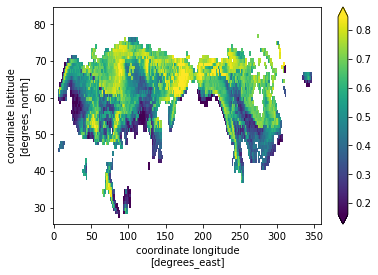

In [13]:
firstY= [90, 220] #first and last years to sample
lastY = [120,250]
BAS = ds.isel(time=slice(firstY[0],lastY[0])).get(['MaxSnow','TotQrun'])
SSP = ds.isel(time=slice(firstY[1],lastY[1])).get(['MaxSnow','TotQrun'])
#corrData
BAScorr = xr.corr(BAS.MaxSnow,BAS.TotQrun,dim=['ens','time'])
SSPcorr = xr.corr(SSP.MaxSnow,SSP.TotQrun,dim=['ens','time'])

BAScorr.plot(robust=True) ;

### Reviewer 1 asked for change in regression slop spread
- Define function to calculate slope of linear relationship, for each grid and ensemble member over time
- Calculate regressoin slopes
- Then difference standard dev. of SSP from Baseline  

In [14]:
def ens_slope(x, y):     
    x_mean = x.mean('time')
    y_mean = y.mean('time')
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum('time')
    B1_den = ((x - x_mean)**2).sum('time')
    B1 = B1_num / B1_den
    return (B1)

In [15]:
BASslope = ens_slope(BAS.MaxSnow,BAS.TotQrun)
SSPslope = ens_slope(SSP.MaxSnow,SSP.TotQrun)

# chack results with plots above
plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'
print(BASslope.sel(lat = plat, lon = plon, method='nearest').mean().values)
print(SSPslope.sel(lat = plat, lon = plon, method='nearest').mean().values)


0.9056451016966902
0.6089138586732965


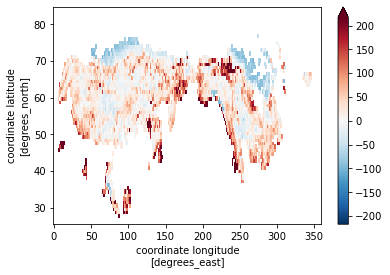

In [16]:
# Normalize change in slope variation, as in Fig 4c-d [see cells below]
# but for Slope of MaxSWE~TotRunoff regressons
normSlopeChange = 100*((SSPslope.std('ens')-BASslope.std('ens'))/BASslope.std('ens')).compute()
normSlopeChange.plot(robust=True) ;

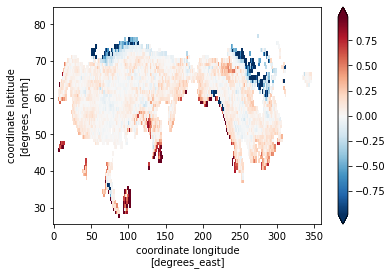

In [17]:
# if we don't normatize the change in STD, based on historical:
(SSPslope.std('ens')-BASslope.std('ens')).plot(robust=True) ;

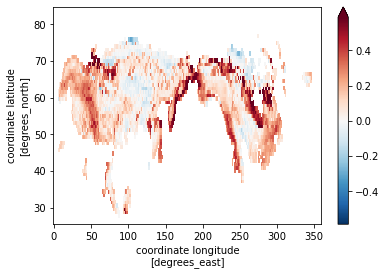

In [18]:
(BAScorr-SSPcorr).plot(robust=True) ;

--------------
## Calculate ensemble means, stats and time of emergence

In [19]:
%%time
# ensemble mean of annual data
ds_ensMean = ds.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ds.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

# add attributes
for ii in ds.data_vars:
    ds_ensMean[ii].attrs = ds[ii].attrs
    ds_ensStd[ii].attrs = ds[ii].attrs

CPU times: user 911 ms, sys: 1.14 s, total: 2.05 s
Wall time: 12.7 s



#### Length of snow free season & change over time

In [20]:
def changePlots (plotVar,vmin1=0,vmax1=350,cmap2='OrRd'):
    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')

    # 1850's 
    ax1.set_title(ds_ensMean[plotVar].attrs['long_name']+", 1850's",
                  loc='left', fontsize='large', fontweight='bold')
    ds_ensMean[plotVar].isel(time=slice(0,10)).mean('time').plot(
        ax=ax1, vmax=vmax1, vmin=vmin1,
        cbar_kwargs={'label': ds_ensMean[plotVar].attrs['long_name']}) ;
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    # 2100 
    ax2.set_title(ds_ensMean[plotVar].attrs['long_name']+", 2090's",
                  loc='left', fontsize='large', fontweight='bold')
    ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time').plot(
        ax=ax2, vmax=vmax1, vmin=vmin1,
        cbar_kwargs={'label': ds_ensMean[plotVar].attrs['long_name']}) ;
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    # Change 2100 - 1901
    ax3.set_title("Change "+ds_ensMean[plotVar].attrs['long_name']+", 2090's-1850's",
                  loc='left', fontsize='large', fontweight='bold')
    temp = ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time') - \
           ds_ensMean[plotVar].isel(time=slice(  0,10  )).mean('time')
    temp.plot(
        ax=ax3, robust=True,#vmax=120,vmin=0, 
        cbar_kwargs={'label': 'Change '+ds_ensMean[plotVar].attrs['long_name']},cmap=cmap2) 
    ax3.set_ylabel('') 
    ax3.set_xlabel('') ; 

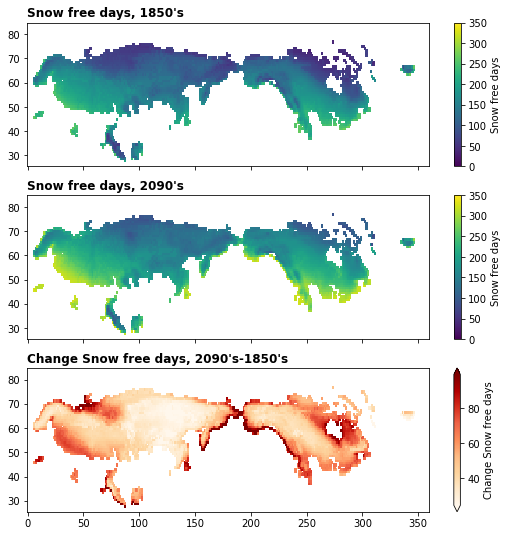

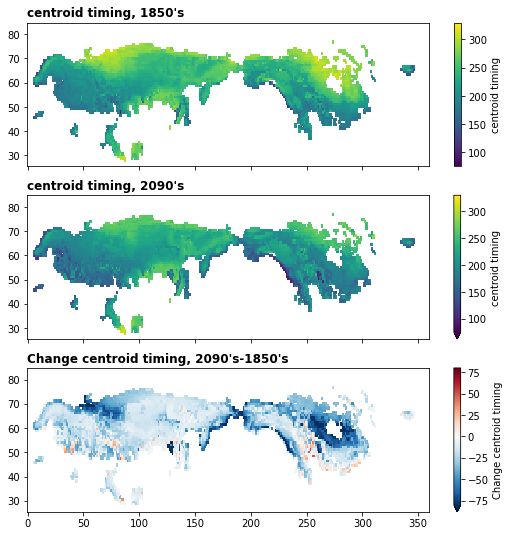

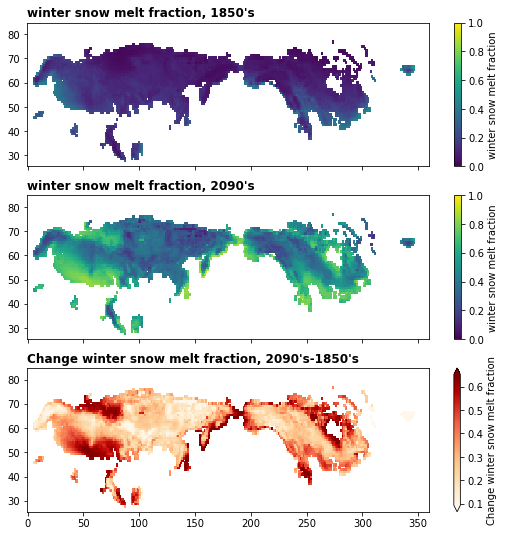

In [21]:
changePlots('SnowFree',cmap2='OrRd')
changePlots('CT',75,330,cmap2='RdBu_r')
changePlots('f_WinMELT',0,1,cmap2='OrRd')


### Different plots to look at regional changes 

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/gla

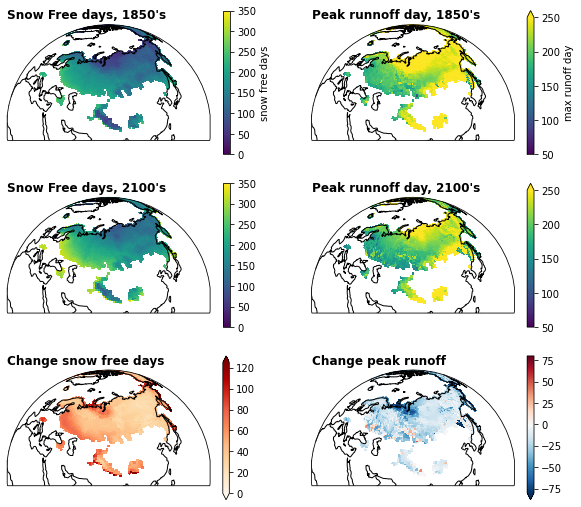

In [22]:
# Number of snow free days
plotVar = ['SnowFree','CT']
lat,lon,region,ortho = [25,80], [0,360], 'Europe', [80,30]
#lat,lon,region,ortho = [35,85], [0,360], 'W. NA',[-100,30]
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(
    3,2, figsize=(10, 9),sharey='row',sharex='col',
    subplot_kw=dict(projection=ccrs.Orthographic(ortho[0], ortho[1])) )

# free days 1901 
ax1.set_title("Snow Free days, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.coastlines()  # cartopy function

ax2.set_title("Peak runnoff day, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.coastlines()  # cartopy function

# free days 2100 
ax3.set_title("Snow Free days, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.coastlines()  # cartopy function

ax4.set_title("Peak runnoff day, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.coastlines()  # cartopy function

# Change  2100 - 1901
ax5.set_title("Change snow free days",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[0]].isel(time=slice(  0,10  )).mean('time')).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.coastlines()  # cartopy function

ax6.set_title("Change peak runoff ",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[1]].isel(time=slice(  0,  10)).mean('time')).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),  # this is important!
    robust=True, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  
ax6.coastlines() ;  # cartopy function

--------------
## Time of emergence & variability stats
- Start by looking at a single gridcell

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/gla

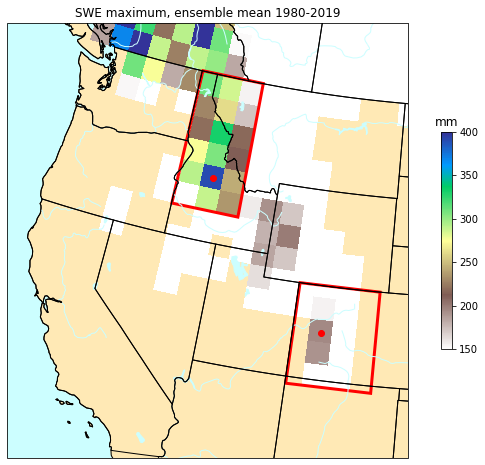

In [23]:
#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
plat = [39,44.7]
plon = [252.5,360-115]
site = ['Crested Butte, CO','Frank Church Wilderness, ID']
ftime, ltime = 130, 169 # select time window to plot
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

sno_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
            'SnowFree','MaxQrun','CT','TotQrun',
           'f_WinMELT']
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

#plat2 = [40.0, 39 ]  
#plon2 = [(360-105.4), 253]

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([36.7,  36.7, 41, 41])
lon_corners = np.array([ (360-109), (360-104.5), (360-104.5), (360-109)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([43.3,  43.3, 49, 49])
lon_corners = np.array([ (360-117), (360-113.1), (360-113.1), (360-117)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, max snow from single ensemble in first decade ==
cf = ax.pcolormesh(ds.lon, ds.lat, ds.MaxSnow.isel(time=slice(ftime,ltime)).mean(dim=['time','ens']), 
                   vmin=150,vmax=400, cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('mm')
ax.set_title("SWE maximum, ensemble mean "+
             str(ds.time.isel(time=ftime).values)+"-"+
             str(ds.time.isel(time=ltime).values));
plt.plot(plon, plat,
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.show()

#dsREG.H2OSNO.max(dim='time').isel(ens=1).plot(robust=True)
#dsREG = dsREG.mean(dim=['lat','lon'])


''

<Figure size 1008x792 with 0 Axes>

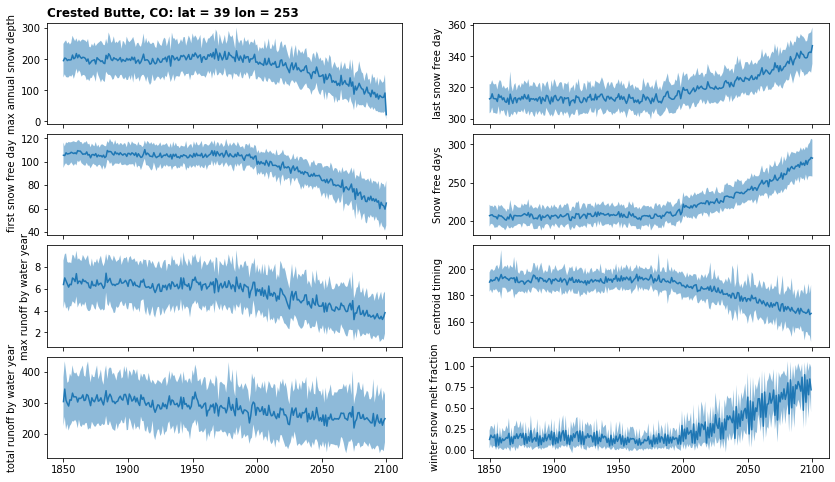

In [24]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
        
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(ds[sno_vars[v]].attrs['long_name']) ;
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') 
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0
;

### Flavio defined ToE as time when 10 year running mean > baseline
- 30 year baseline (1940-1969)
- 10 year running mean

In [25]:
# ensemble mean and std over first 30 years
dsBase    = ds.isel(time=slice(90,120)).mean(dim=['time','ens']).compute()
dsBaseStd = ds.isel(time=slice(90,120)).std(dim=['time','ens']).compute()

#### Take 10 year rolling mean of each ensemble and calculate ensemble statistics.

In [26]:
%%time 
ds_roll = ds.rolling(time=10, center=True).mean().compute()

# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
_ = wait(roll_ensMean)
roll_ensStd  = ds_roll.std('ens').compute()
_ = wait(roll_ensStd)

CPU times: user 40.8 s, sys: 1min 7s, total: 1min 48s
Wall time: 1min 53s


#### Plot: 
* ensemble mean & standard deviation
* rolling mean & rolling std
* base mean and std (all ensembles over first 20 years)

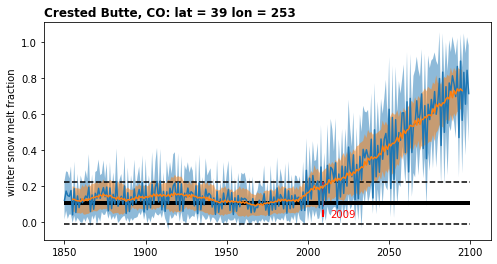

In [27]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
#plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
testVar = 'f_WinMELT'
plt.figure(figsize=[8,4])
x = ds_ensMean.time
y = ds_ensMean[testVar].sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd[testVar].sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel(ds[testVar].attrs['long_name']) ;

x = roll_ensMean.time
y = roll_ensMean[testVar].sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd[testVar].sel(lat = plat, lon = plon, method='nearest')
plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

plt.hlines(dsBase[testVar].sel(lat = plat, lon = plon, method='nearest'), 1850, 2100, colors='k',lw=4) ;
plt.hlines((dsBase[testVar] + dsBaseStd[testVar]).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') ;
plt.hlines((dsBase[testVar] - dsBaseStd[testVar]).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<dsBase[testVar].sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*2.2,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

#### Test code for all variables
 - check these results with Fig 1, S2

<Figure size 1008x792 with 0 Axes>

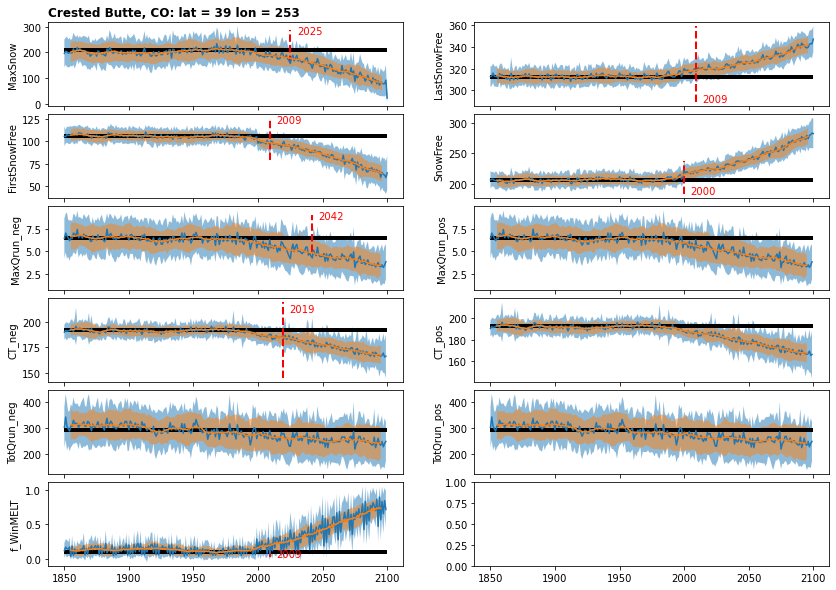

In [28]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 
#plat, plon, site =  40.45, 360-105.75, 'Rocky Mountain NP'
#plat, plon, site =  44.66, 360-111.09, 'Yellowstone NP'
#plat, plon, site =  48.5 , 360-113.97,  'Glacier NP'
#plat,plot,site  = 38, 360-108, 'Telluride, CO'
#plat,plon,site = 44.7, 360-115, 'Frank Church Wilderness, ID'

in_vars = ['MaxSnow','LastSnowFree',
           'FirstSnowFree','SnowFree',
           'MaxQrun','MaxQrun',
           'CT','CT',
           'TotQrun','TotQrun',
          'f_WinMELT']
sno_vars = ['MaxSnow','LastSnowFree',
            'FirstSnowFree','SnowFree',
            'MaxQrun_neg','MaxQrun_pos',
            'CT_neg','CT_pos',
            'TotQrun_neg','TotQrun_pos','f_WinMELT']
sno_trend = ['neg','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos','pos']

plt.figure(figsize=[14,11])
fig, axs = plt.subplots(6,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,10))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')

    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(sno_vars[v]) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase[in_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1850, 2100, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)
    #draw ToE lines
    if ToE <2095:
        if sno_trend[v] == 'pos': 
            axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.15,colors='r',
                            lw=2,linestyles='dashed') ;
            axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
        else: 
            axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                            lw=2,linestyles='dashed') ;
            axs[i,j].text(ToE+5, test.max()*1.05, ToE.values,color='r')
    # Add title
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0 ;

#### Time of emergence globally

In [29]:
# Back to big list of variables

in_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
           'SnowFree','f_WinMELT','f_WinMELT',
           'MaxQrun','MaxQrun',
           'CT','CT',
           'TotQrun','TotQrun']
sno_vars = ['MaxSnow','LastSnowFree','FirstSnowFree',
            'SnowFree','f_WinMELT_pos','f_WinMELT_neg',
            'MaxQrun_neg','MaxQrun_pos',
            'CT_neg','CT_pos',
            'TotQrun_neg','TotQrun_pos']
sno_trend = ['neg','pos','neg',
             'pos','pos','neg',
             'neg','pos',
             'neg','pos',
             'neg','pos']

In [30]:
import cartopy.crs as ccrs
# find ToE for Snow free days when roll mean - 2 std < baseline
test = roll_ensMean.SnowFree - 2*roll_ensStd.SnowFree
test = test.where(test<dsBase.SnowFree)
GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
print(GOI.time.max())#isel(time=-1))
#GOI.plot()

test.time.max()#.groupby()['time'].max()
#test.time.dropna('time').plot()
#test = test.idxmax(dim='time')
#test.where(test>1850).sel(lon=slice(5,44),lat=slice(50,77)).plot(    
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={
    #    "projection": ccrs.LambertConformal(
    #        central_longitude=0, central_latitude=60
    #    )
    #},
#    robust=True) ;
#print(test)

<xarray.DataArray 'time' ()>
array(2000)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11


<xarray.DataArray 'time' ()>
array(2100)

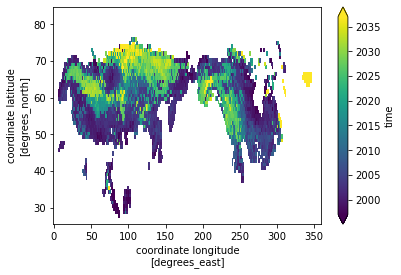

In [31]:
ToE_coords = test.coords
ToE = xr.Dataset(coords=ToE_coords)

for v in range(len(sno_vars)):
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[in_vars[v]] - 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp<dsBase[in_vars[v]])
    else:
        temp = roll_ensMean[in_vars[v]] + 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp>dsBase[in_vars[v]])
    
    if v == 3:
        #print(temp.max(dim='time'))
        temp.max(dim='time').plot(robust=True)
    ToE[sno_vars[v]] = temp.max(dim='time')

    ToE = ToE.where(ToE>1850)
    ToE = ToE.where(ToE<2095)

---------
### Changes in global temperature, to plot temperature of emergence

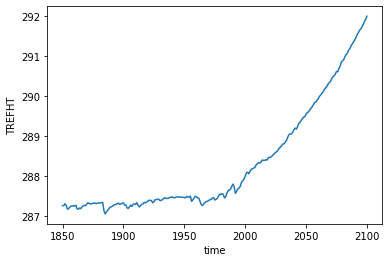

In [32]:
## from Isla (on cgd machines /project/cas/islas/python_savs/for/will/GMT_annualmean.nc)
GMT = xr.open_mfdataset('/glade/scratch/wwieder/VernalWindow/GMT_annualmean.nc')
# from Flavio
#GMT2 = xr.open_mfdataset('/glade/scratch/flehner/for_will/TREFHT.ensmean10-50.185001-210012_ts_annual.nc')
# drop extra coordinates & rename year -> time 
#GMT2['TREFHT'] = GMT2.TREFHT.isel(lat=0, lon=0)
GMT = GMT.rename({'year': 'time'})
#GMT2['time'] = GMT['time']
GMT.TREFHT.plot() ;
#GMT2.TREFHT.plot() ;

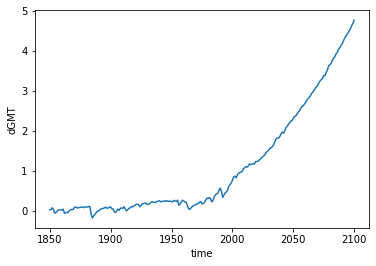

In [33]:
GMT['dGMT'] = GMT.TREFHT - GMT.TREFHT.isel(time=slice(0,20)).mean()
GMT['dGMT'].plot() ;

In [34]:
newlabel = [1,2,3,4] # labels of the ticklabels: the position in the new axis
newpos = [0,0,0,0]

x = GMT['dGMT']
for i in range(len(newlabel)):
    temp = x.time.where(x<newlabel[i]).max()
    newpos[i] = [x.time.where(x<newlabel[i]).max().values]
newpos


[[array(2008.)], [array(2043.)], [array(2066.)], [array(2086.)]]

In [35]:
# not surey why I con't drop arrays... just to this manually now
newpos = [2008,2043,2066,2086]

-----
## *map_function*

In [36]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy

# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap='viridis', newlabel=newlabel,newpos=newpos, 
                 panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    #land = ax.add_feature(
    #    cfeature.NaturalEarthFeature('physical','land','110m', facecolor='grey',alpha=0.05))
    cmap = copy.copy(plt.get_cmap(cmap))
    cmap.set_bad( "gray", alpha=0.05 )
    #cmap.set_under( "white", alpha=1 )
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)

    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.07, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.07, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')

    # special colorbar that adds temperature change to time of emermgence plots   
    if cb == 3:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.07, orientation='horizontal')

        pos = cbar.ax.get_position()
        ax1 = cbar.ax
        #ax1.set_aspect('auto')

        # create a second axis and specify ticks based on the relation between the first axis and second aces
        ax2 = ax1.twiny()
        ax2.set_xlim([vmin,vmax])
        ax2.set_xticks(newpos)
        ax2.set_xticklabels(newlabel)

        # resize the colorbar
        pos.y1 -= 0.04
        pos.y0 -= 0.04


        # arrange and adjust the position of each axis, ticks, and ticklabels
        ax1.set_position(pos)
        ax2.set_position(pos)
        ax1.set_xlabel(units,size=12,fontweight='bold')
        ax1.xaxis.set_ticks_position('bottom') # set the position of the first axis to right
        ax1.xaxis.set_label_position('bottom') # set the position of the fitst axis to right
        ax2.set_xlabel(u'Global Mean Temperature Change (\u2103)',fontweight='bold')
        ax2.xaxis.set_ticks_position('top') # set the position of the second axis to right
        ax2.xaxis.set_label_position('top') # set the position of the second axis to right




/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

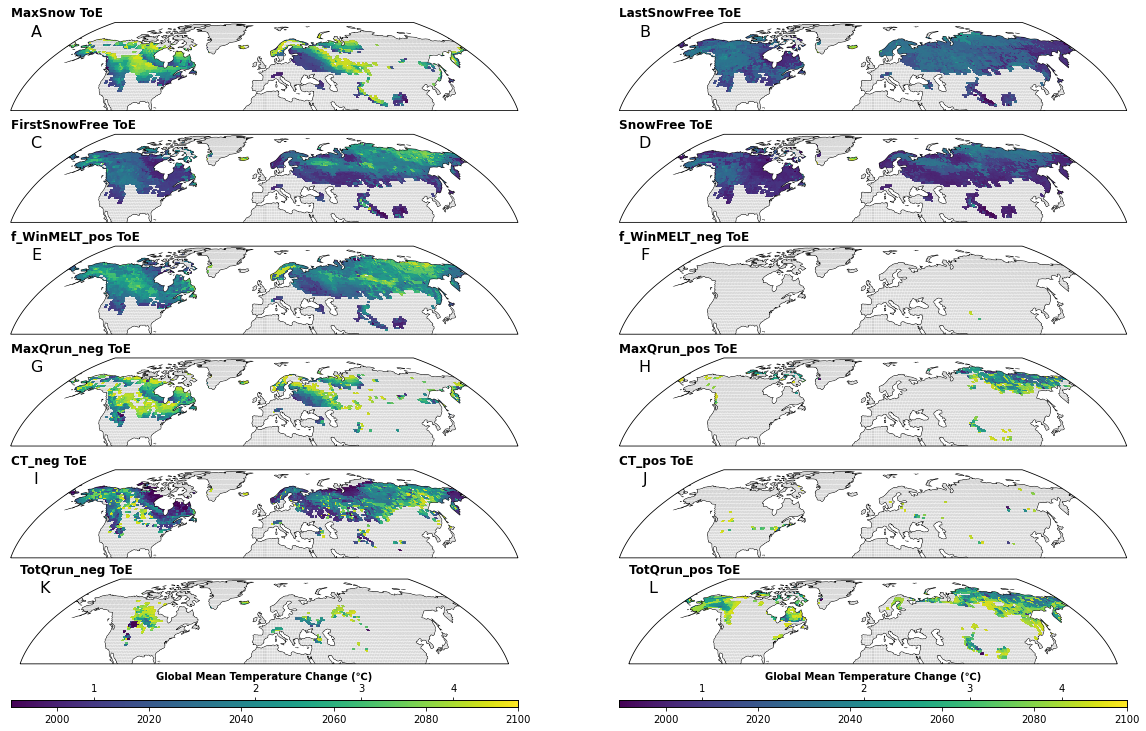

In [37]:
#---------------------
# Now call the map_function

panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(j)','(k)','(l)','(m)']  
panel = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 
         'H', 'I', 'J', 'K', 'L', 'M']

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,12), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,0,0,0,0,0,0,0,3,3]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ToE[sno_vars[i]]
    map_function(da, panel=panel[i], ax=ax, title=sno_vars[i]+' ToE', 
                 vmin=1990, vmax=2100, cb=cb[i])

    i = i+1

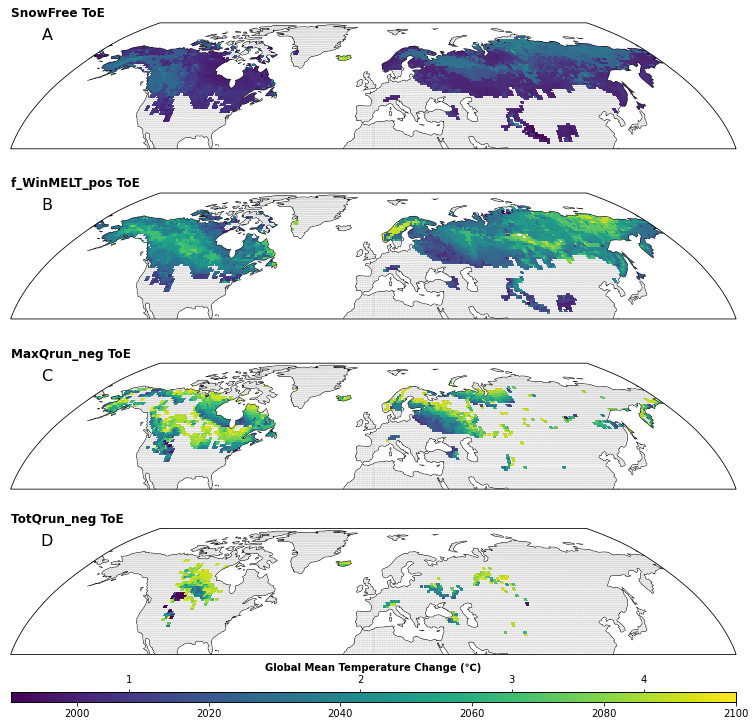

In [38]:
#removed 'LastSnow',
pltVars = ['SnowFree','f_WinMELT_pos','MaxQrun_neg','TotQrun_neg']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13,12), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,3]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1



### Plot mean change, stdev change and TOE for individual variables
- changes 2070-2999 from 1940-1969
- Isla recommended removing the ensemble mean from each year before calculating the SD


In [39]:
# Remove ensemble mean
dsTD = ds - ds.mean('ens')

In [40]:
meanFIN = ds.isel(time=slice(-31, -1)).mean('time')
meanINI = ds.isel(time=slice( 90,120)).mean('time')
meanChange = (meanFIN.mean('ens')-meanINI.mean('ens')).compute()

sdFIN = dsTD.isel(time=slice(-30,None)).std('time')
sdINI = dsTD.isel(time=slice( 90,120)).std('time')
sdChange = 100*((sdFIN-sdINI)/sdINI).mean('ens').compute()

cvFIN = 100*(sdFIN/meanFIN).mean('ens')
cvINI = 100*(sdINI/meanINI).mean('ens')
cvChange = (cvFIN-cvINI).compute()

# add attributes
for ii in meanChange.data_vars:
    meanChange[ii].attrs = ds[ii].attrs
    sdChange[ii].attrs = ds[ii].attrs
    cvChange[ii].attrs = ds[ii].attrs
    


In [41]:
# Get all signficant ToE Value (pos or neg)
ToE['CT'] = ToE.CT_neg.where(ToE.CT_neg.notnull(),ToE.CT_pos)
ToE['TotQrun'] = ToE.TotQrun_neg.where(ToE.TotQrun_neg.notnull(),ToE.TotQrun_pos)
#Fill ToE with NA when it never occurs
#    ToE = ToE.where(ToE<2095)
#meanChange.f_WinMELT

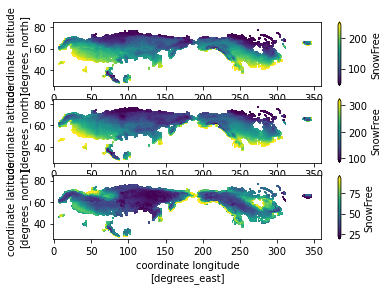

In [42]:
tempVar = 'SnowFree'
plt.subplot(311)
a = ds[tempVar].isel(time=slice(0,20)).mean('time')
a.mean('ens').plot(robust=True)
plt.subplot(312)
b = ds[tempVar].isel(time=slice(-20,None)).mean('time')
b.mean('ens').plot(robust=True)
plt.subplot(313)
c = b-a
c.mean('ens').plot(robust=True) ;
#meanChange[tempVar].attrs

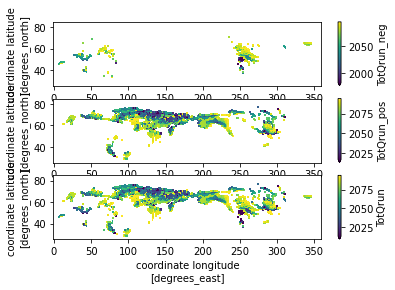

In [43]:
plt.subplot(311)
ToE.TotQrun_neg.plot(robust=True)

plt.subplot(312)
ToE.TotQrun_pos.plot(robust=True)

plt.subplot(313)
ToE.TotQrun.plot(robust=True) ;

In [44]:
panel2 = [['(a)','(c)','(e)'],['(b)','(d)','(f)']]
panel2 = [['A','C','E'],['B','D','F']]
panel2[0][1]

'C'

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

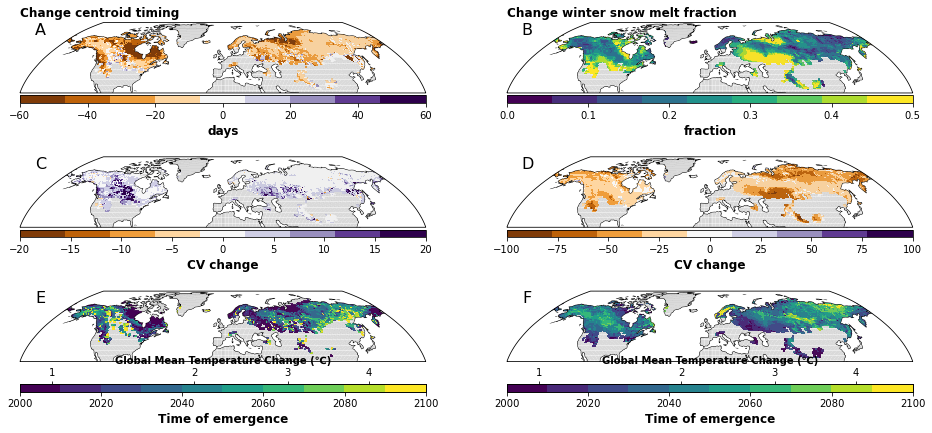

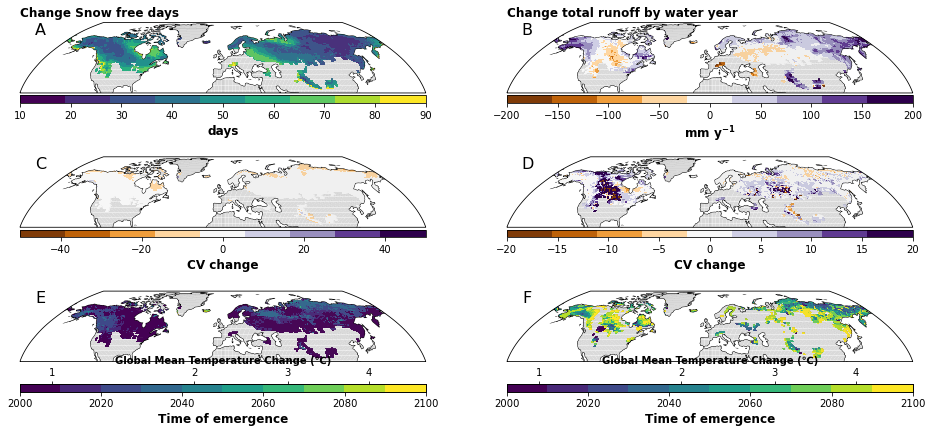

In [45]:
pltData = ['ensemble mean change','ensemble CV change','time of emergence ']

for h in range(2):
    if h == 0: 
        pltVars = ['CT','f_WinMELT']
        ToEVars = ['CT_neg','f_WinMELT_pos']
    else:
        pltVars = ['SnowFree','TotQrun']
        ToEVars =['SnowFree','TotQrun']

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,7), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

    # loop over plots to make
    j = 0 #select variable
    i = 0 # plot/panel counter
    
    for j in range(2):
        #Define range, colorbar and units for variables
        cmapOptC = cm.get_cmap('viridis', 10)

        # Winter Melt and CT
        if h == 0:
            if j == 0:
                vmin, vmax = [-60,-20,2000], [60 ,20 ,2100]
                cmapOptA = cm.get_cmap('PuOr', 9)
                cmapOptB = cm.get_cmap('PuOr', 9)
                units = 'days'
            if j == 1:
                vmin, vmax = [0,-100,2000], [0.5 ,100 ,2100]
                cmapOptA = cm.get_cmap('viridis', 9)
                cmapOptB = cm.get_cmap('PuOr', 9)
                units = 'fraction'
        # Runoff
        if h == 1:
            if j == 0:
                vmin, vmax = [10,-50,2000], [90 ,50 ,2100]
                cmapOptA = cm.get_cmap('viridis', 9)
                cmapOptB = cm.get_cmap('PuOr', 9)
                units = 'days'
            if j == 1:
                vmin, vmax = [-200,-20,2000], [200 ,20 ,2100]
                cmapOptA = cm.get_cmap('PuOr', 9)
                cmapOptB = cm.get_cmap('PuOr', 9)
                units = 'mm $\mathregular{y^{-1}}$'
    
        for i in range(3):
            #i = index[0]
            if i ==0: 
                dataIn = meanChange[pltVars[j]]
                cmap   = cmapOptA  
                units  = units
                title  = 'Change '+meanChange[pltVars[j]].attrs['long_name']
                cb     = 1
            if i ==1: 
                dataIn = cvChange[pltVars[j]]
                cmap   = cmapOptB
                #units  = '% change '+r'$\sigma$'
                units  = 'CV change'
                title  = None
                cb     = 1
            if i ==2: 
                dataIn = ToE[ToEVars[j]]
                #cmap   = 'tab20b_r'
                cmap   = cmapOptC
                units  = 'Time of emergence'
                title  = None
                cb     = 3
            # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
            map_function(dataIn, panel=panel2[j][i], ax=axs[i,j], 
                         title= title, 
                         vmax = vmax[i], vmin = vmin[i], cmap=cmap,
                         cb=cb, units=units) 


Change Snow free days mean =44.61 std = 16.1
Change Snow free days min =-28.03 max = 148.34


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

/glade/scratch/wwieder/VernalWindow/FigS8_SnowFreeDays.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for mul

Change winter snow melt fraction mean =0.29 std = 0.13
Change winter snow melt fraction min =-0.16 max = 0.75


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

/glade/scratch/wwieder/VernalWindow/Fig4a_fWinterMelt.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for mul

Change centroid timing mean =-22.53 std = 18.56
Change centroid timing min =-110.18 max = 42.82


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

/glade/scratch/wwieder/VernalWindow/Fig4b_CenterTiming.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for mul

Change total runoff by water year mean =42.15 std = 66.03
Change total runoff by water year min =-276.14 max = 1334.42
/glade/scratch/wwieder/VernalWindow/FigS9_TotalRunoff.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for mul

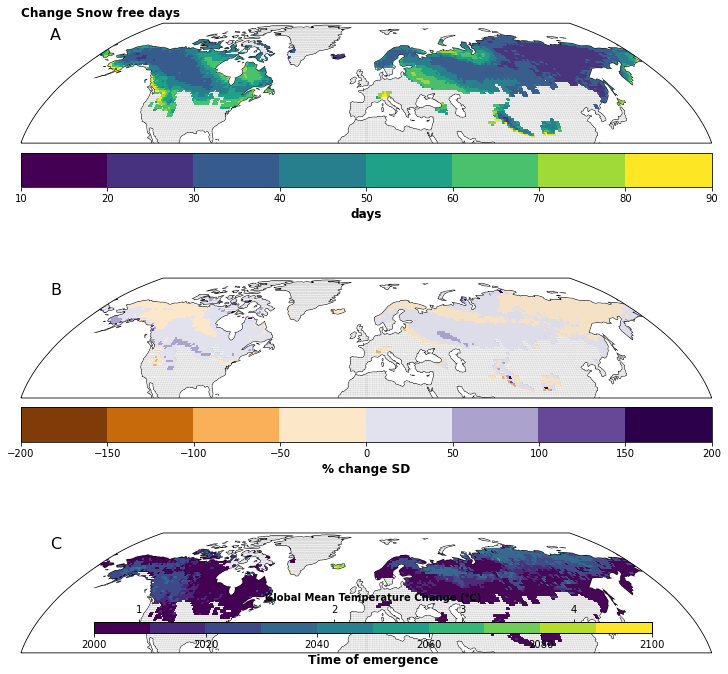

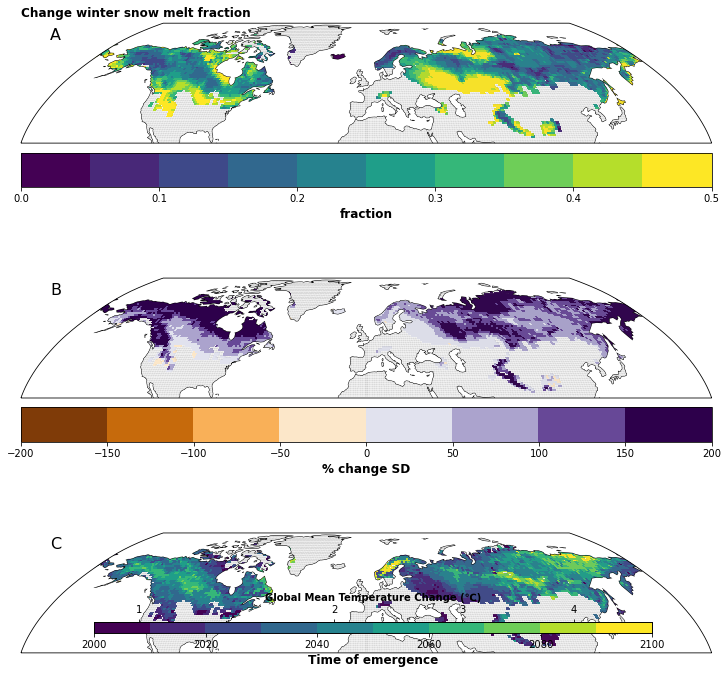

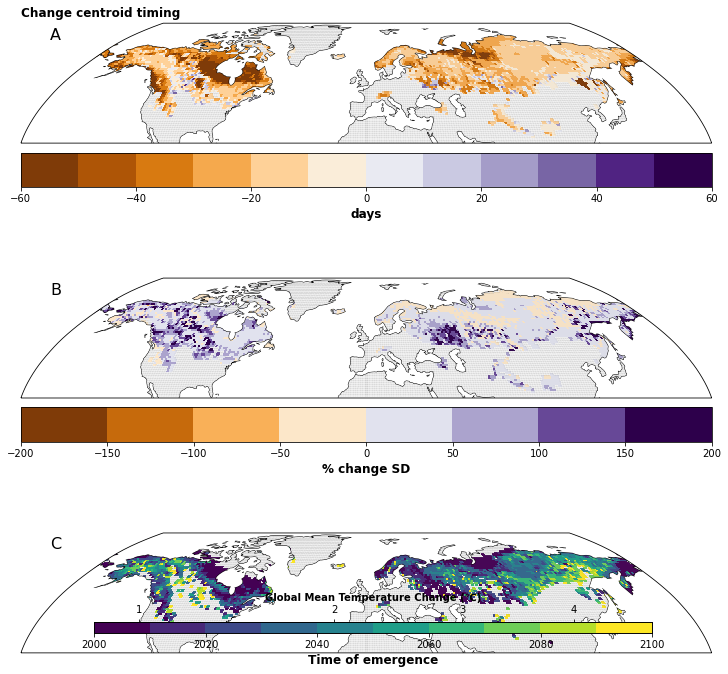

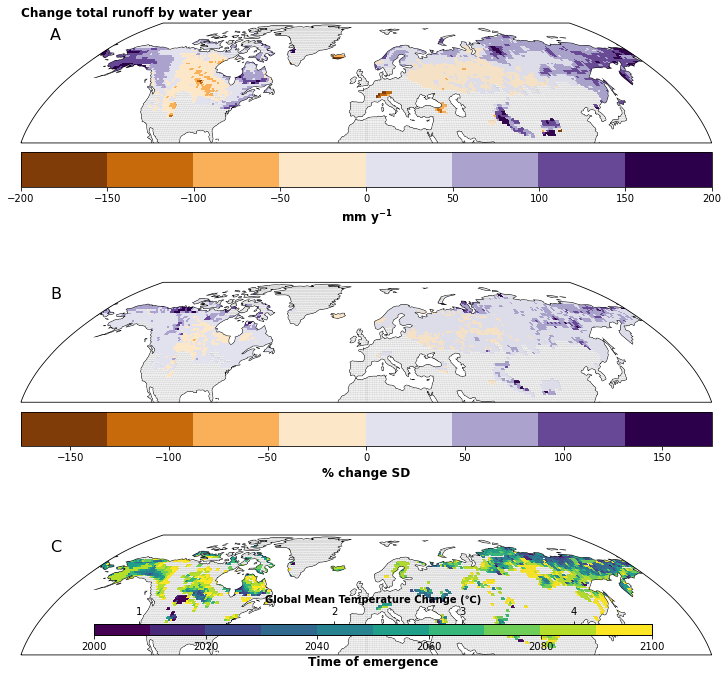

In [46]:
# TRY MAKING SAME PLOTS W/ JUST 3 PANELS
pltData = ['ensemble mean change','ensemble CV change','time of emergence ']

pltVars = ['SnowFree','f_WinMELT','CT','TotQrun']
ToEVars = ['SnowFree','f_WinMELT_pos','CT_neg','TotQrun']
fout = ['FigS8_SnowFreeDays','Fig4a_fWinterMelt','Fig4b_CenterTiming','FigS9_TotalRunoff']
#fout = [i + j for i, j in zip(fout,pltVars)]  
for j in range(len(pltVars)):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
    #Define range, colorbar and units for variables
    # Snow variables
    if j == 0:
        vmin, vmax = [10,-200,2000], [90 ,200 ,2100]
        cmapOptA = cm.get_cmap('viridis', 8)
        cmapOptB = cm.get_cmap('PuOr', 8)
        units = 'days'
    if j == 1:
        vmin, vmax = [0,-200,2000], [0.5 ,200 ,2100]
        cmapOptA = cm.get_cmap('viridis', 10)
        cmapOptB = cm.get_cmap('PuOr', 8)
        units = 'fraction'
    # Runoff
    if j == 2:
        vmin, vmax = [-60,-200,2000], [60 ,200 ,2100]
        cmapOptA = cm.get_cmap('PuOr', 12)
        cmapOptB = cm.get_cmap('PuOr', 8)
        units = 'days'
    if j == 3:
        vmin, vmax = [-200,-175,2000], [200 ,175 ,2100]
        cmapOptA = cm.get_cmap('PuOr', 8)
        cmapOptB = cm.get_cmap('PuOr', 8)
        units = 'mm $\mathregular{y^{-1}}$'
    
    for i in range(3):
        #i = index[0]
        if i ==0: 
            dataIn = meanChange[pltVars[j]]
            cmap   = cmapOptA  
            units  = units
            cb = 1
            title  = 'Change '+meanChange[pltVars[j]].attrs['long_name']
            print(title+' mean ='+str(np.round((dataIn.mean().values),2))+
                                ' std = '+str(np.round((dataIn.std().values),2)))
            print(title+' min ='+str(np.round((dataIn.min().values),2))+
                                ' max = '+str(np.round((dataIn.max().values),2)))
        if i ==1: 
            dataIn = sdChange[pltVars[j]]
            cmap   = cmapOptB
            units  = '% change SD'#+r'$\sigma$'
            title  = None
            cb = 1
        if i ==2: 
            dataIn = ToE[ToEVars[j]]
            #cmap   = 'tab20b_r'
            cmap = cm.get_cmap('viridis', 10)
            units  = 'Time of emergence'
            title  = None
            cb = 3
        # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
        map_function(dataIn, panel=panel[i], ax=axs[i], 
                     title= title, 
                     vmax = vmax[i], vmin = vmin[i], cmap=cmap,
                     cb=cb, units=units) 
    pathIN = '/glade/scratch/wwieder/VernalWindow/'
    fileOUT =  pathIN + fout[j]+'.pdf'
    print(fileOUT)
    plt.savefig(fileOUT)


In [47]:
pltVars[i]

'CT'

In [48]:
normSlopeChange

<xarray.DataArray (lat: 63, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35

#### Plots of Annual SWE ~ Runoff Correlation, fig 6b-d

Baseline Correlation mean = 0.56 std = 0.19


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

Correlation change under SSP3-7.0 mean = -0.14 std = 0.17


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

% change $\sigma$ of slope mean = 32.56 std = 68.62
/glade/scratch/wwieder/VernalWindow/Fig5b_SWE_RUNOFF_CORR.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for mul

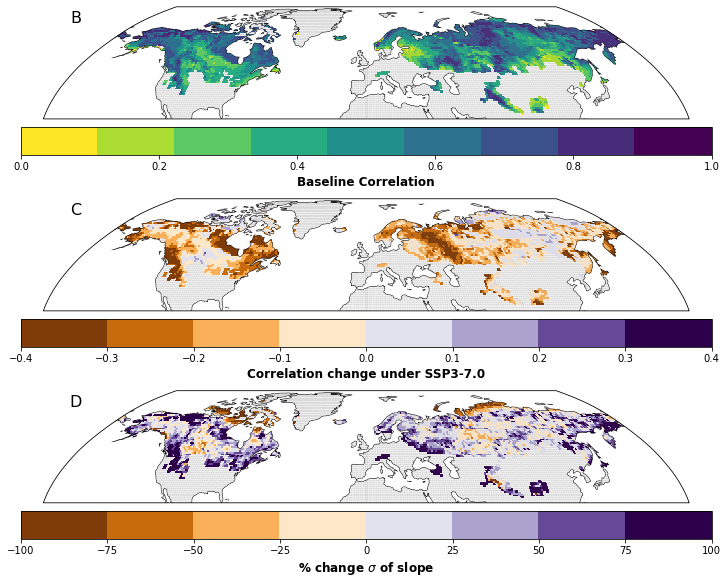

In [49]:
DIFcorr = SSPcorr - BAScorr 
pltVars = (BAScorr, DIFcorr, SSPcorr)
normSlopeChange

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,8), constrained_layout=True,
                        subplot_kw=dict(projection=ccrs.Robinson()))
            
for i in range(len(pltVars)):
    dataIn = pltVars[i]
    if i ==0: 
        cmap   = cm.get_cmap('viridis_r', 9)
        units  = 'Baseline Correlation'
        #title  = 'Annual SWE ~ Runoff Correlation'
        title = None
        vmax,vmin = 1,0
    if i ==1: 
        cmap   = cm.get_cmap('PuOr', 8)
        units  = 'Correlation change under SSP3-7.0'
        title  = None
        vmax,vmin = 0.4,-0.4
    if i == 2: 
        dataIn = normSlopeChange
        cmap   = cm.get_cmap('PuOr', 8)
        units  = '% change '+r'$\sigma$'+' of slope'
        title  = None
        vmax,vmin = 100,-100

    print(units+' mean = '+str(np.round((dataIn.mean().values),2))+
                ' std = '+str(np.round((dataIn.std().values),2)))
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(dataIn, panel=panel[(i+1)], ax=axs[i], 
                 title= title, 
                 vmax = vmax, vmin = vmin, cmap=cmap,
                 cb=1, units=units) 

pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathIN + 'Fig5b_SWE_RUNOFF_CORR.pdf'
print(fileOUT)
plt.savefig(fileOUT)


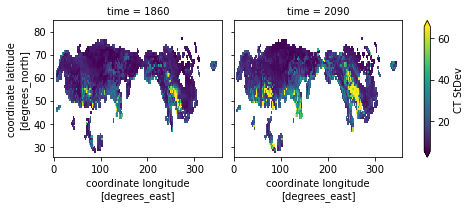

In [50]:
plotVar = 'CT'
ds_ensStd[plotVar].isel(time=[10,-11]).plot(y='lat',x='lon',col="time",
                                            col_wrap=2, robust=True,
                                            cbar_kwargs={"label": plotVar+" StDev",
                                            "pad": 0.05 }  # passed to plt.colorbar
                                           ) ;

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/pytho

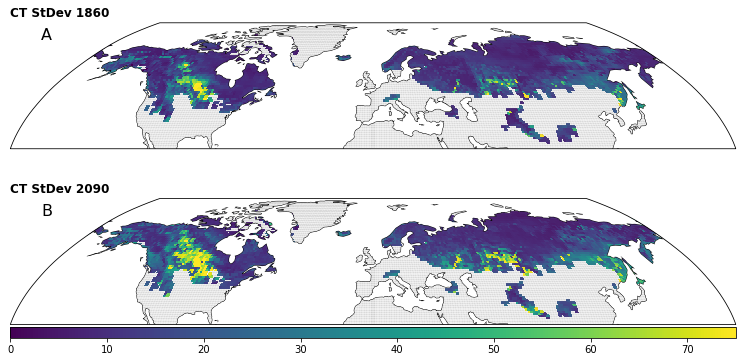

In [51]:
plotVar = 'CT'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
timePlot= [10,-11]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    year = str(ds_ensStd.time.isel(time=10).values)
    map_function(ds_ensStd[plotVar].isel(time=timePlot[i]), 
                 panel=panel[i], ax=ax, 
                 title= plotVar + ' StDev ' +
                        str(ds_ensStd.time.isel(time=timePlot[i]).values), 
                 cb=cb[i], vmin=0, vmax=75) 

    i = i+1

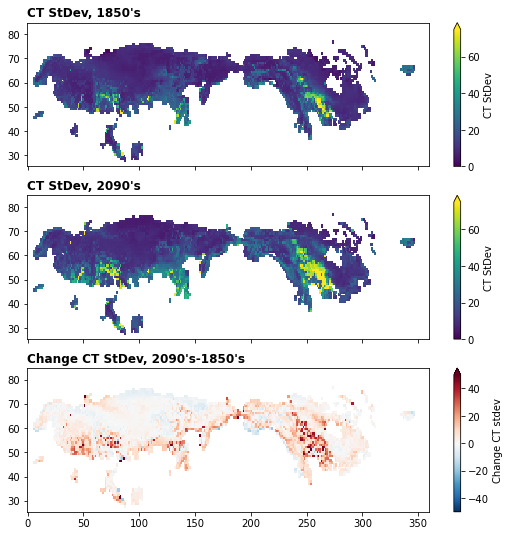

In [52]:
# Change in max runoff date std
plotVar = 'CT'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title(plotVar+" StDev, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=75, vmin=0,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title(plotVar+" StDev, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=75, vmin=0,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change "+plotVar+" StDev, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensStd[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=50, vmin=-50, 
    cbar_kwargs={'label': 'Change '+plotVar+' stdev'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/sit

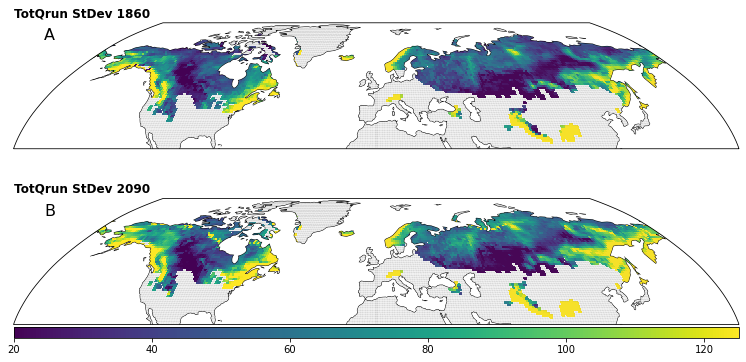

In [53]:
plotVar = 'TotQrun'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
timePlot= [10,-11]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    year = str(ds_ensStd.time.isel(time=10).values)
    map_function(ds_ensStd[plotVar].isel(time=timePlot[i]), 
                 panel=panel[i], ax=ax, 
                 title= plotVar + ' StDev ' +
                        str(ds_ensStd.time.isel(time=timePlot[i]).values), 
                 cb=cb[i], vmin=20, vmax=125) 

    i = i+1

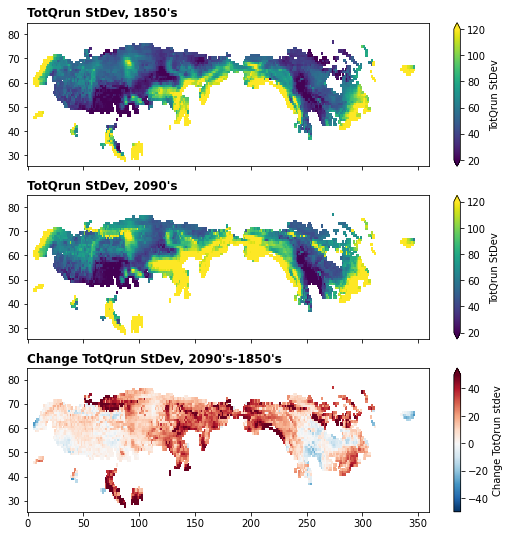

In [54]:
# Change in total runoff variation
plotVar = 'TotQrun'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title(plotVar+" StDev, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=120, vmin=20,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title(plotVar+" StDev, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=120, vmin=20,
    cbar_kwargs={'label': plotVar+' StDev'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change "+plotVar+" StDev, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensStd[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensStd[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=50, vmin=-50, 
    cbar_kwargs={'label': 'Change '+plotVar+' stdev'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

## global runoff

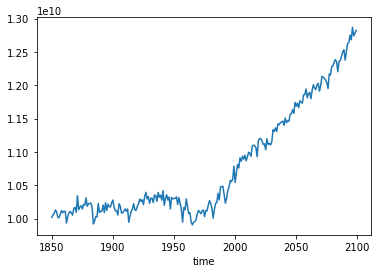

In [55]:
globRunoff = (ds.TotQrun * la).sum(['lat','lon']) 
globRunoff = globRunoff.isel(time=slice(0,-1)).compute()
globBase = globRunoff.isel(time=slice(90,120)).mean(['ens','time'])
globRunoff.mean('ens').plot()

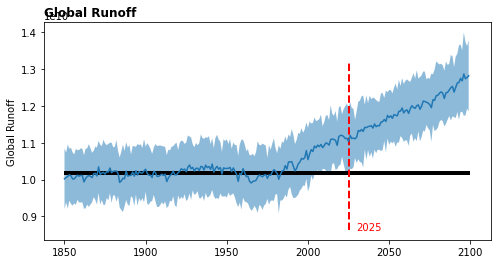

In [56]:
plt.figure(figsize=[8,4])
x = globRunoff.time
y = globRunoff.mean('ens')
y2 = globRunoff.std('ens')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)
plt.ylabel('Global Runoff') ;


plt.hlines(globBase, 1850, 2100, colors='k',lw=4) ;
plt.title('Global Runoff',loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<globBase).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*1.3,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

-------------
### End of Notebook

In [57]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2022-05-27

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 35c7be9dd2750a64840e06f95e61e1ef25a3d2fd

Git repo: https://github.com/wwieder/CESM2-LE_SnowWater.git

Git branch: main

cftime    : 1.4.1
matplotlib: 3.3.4
numba     : 0.52.0
xarray    : 0.17.0
pandas    : 1.2.3
numpy     : 1.20.1
cartopy   : 0.18.0
dask      : 2021.6.2
scipy     : 1.6.0



-------------